Julio B. Roll - PS3

Estimating macro data.

Brock and Mirman Model:

$$ (c_t)^{-1} - \beta E[r_{t+1}(c_{t+1})^{-1}] = 0 \tag{1} $$ <br>
$$ c_t + k_{t+1} - \omega_t - r_tk_t = 0 \tag{2} $$ <br>
$$ \omega_t - (1 - \alpha)e^{z_t}(k_t)^\alpha = 0 \tag{3} $$ <br>
$$ r_t - \alpha e^{z_t}(k_t)^{\alpha - 1} = 0 \tag{4} $$ <br>
$$ z_t = \rho z_{t-1} + (1 - \rho)\mu + \epsilon_t \tag{5} $$ <br>
$$ \text{where}\: \epsilon_t \sim \mathrm{N}(0, \sigma^2)\: \text{and}\: \alpha,\beta \in (0,1), \: \mu, \sigma > 0, \: \rho \in (-1,1) $$

In [224]:
# importing our data series
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as spc
import distribs

macro_data = np.loadtxt('MacroSeries.txt', delimiter = ',')
c_t = macro_data[:,0]
k_t = macro_data[:,1]
omega_t = macro_data[:,2]
r_t = macro_data[:,3]
beta = 0.99

### Question a)

We will use $(\omega_t, k_t)$ and equations (3) and (5) to estimate by ML $(\alpha, \rho, \mu, \sigma)$. For that, we can write $z_t$ as:

$$ z_t = ln \Big(\frac{w_t}{(1 - \alpha)k_t^\alpha}\Big) $$
$$ \text{where}\: z_t \sim \mathrm{N}(\rho z_{t-1} + (1 - \rho)\mu,\sigma^2) $$ <br>
which allows us to write our test on our assumption for $\epsilon_t$.

Let's build some auxiliary functions:

In [225]:
def log_lik_norm_a(omega_t, k_t, alpha, rho, mu, sigma):
    '''
    --------------------------------------------------------------------
    Calculates z_t series using equations (3) and (5) of PS3.
    Compute the log likelihood function for data eps_t given normal
    distribution parameter sigma.
    --------------------------------------------------------------------
    INPUTS:
    omega_t = (N,) vector, wages
    k_t     = (N,) vector, capital
    alpha   = scalar, 0 < alpha < 1
    rho     = scalar, 0 < rho < 1
    mu      = scalar > 0
    sigma   = scalar > 0
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    z_t         = (N,) vector, total factor productivity
    z_t_lag     = (N,) vector, lagged total factor productivity (1 period)
    eps_t       = (N,) vector, AR(1) residual for TFP series
    pdf_vals    = (N,) vector, normal PDF values for mu and sigma
                  corresponding to eps_t
    ln_pdf_vals = (N,) vector, natural logarithm of normal PDF values
                  for mu and sigma corresponding to eps_t
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    z_t = np.log(omega_t/((1-alpha) * (k_t)**alpha))
    z_t_lag = np.roll(z_t, 1)
    z_t_lag[0] = mu
    eps_t = z_t - rho * z_t_lag - (1 - rho) * mu
    pdf_vals = distribs.norm_pdf(eps_t, 0, sigma)
    pdf_vals[pdf_vals < 10^-10] = 10^-10
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [226]:
def crit_zt_a(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params  = (4,) vector, ([alpha, rho, mu, sigma])
    alpha   = scalar, 0 < alpha < 1
    rho     = scalar, 0 < rho < 1
    mu      = scalar > 0
    sigma   = scalar > 0
    args    = length 2 tuple, (omega_t, k_t)
    omega_t = (N,) vector, wages
    k_t     = (N,) vector, capital
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_norm_a
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    alpha, rho, mu, sigma = params
    omega_t, k_t = args
    log_lik_val = log_lik_norm_a(omega_t, k_t, alpha, rho, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Optimization routine: I'm doing an unconstrained one first using Nelder-Mead (also "gradient-less"). The idea is to get a "more robust" solution given the initial parameters. Then, use those in a constrained, gradient-based solver.

It converges, but it triggers a couple of warnings. Like in PS2, Nelder-Mead's noise robustness seems more appropriate (and performance is not an issue here):

In [303]:
alpha_init = 0.5
rho_init = 0.5
mu_init = 10
sigma_init = 2

print('alpha_init = ', alpha_init, 'rho_init = ', rho_init, 'mu_init = ', mu_init,
      'sigma_init = ', sigma_init)
params_init = np.array([alpha_init, rho_init, mu_init, sigma_init])
mle_args = (omega_t, k_t)
results1 = opt.minimize(crit_zt_a, params_init, args = (mle_args), method = 'Nelder-Mead')
alpha_MLE_a, rho_MLE_a, mu_MLE_a, sigma_MLE_a = results1.x
print('alpha_MLE_a = ', alpha_MLE_a, 'rho_MLE_a = ', rho_MLE_a, 'mu_MLE_a = ', mu_MLE_a,
      'sigma_MLE_a = ', sigma_MLE_a)

alpha_init =  0.5 rho_init =  0.5 mu_init =  10 sigma_init =  2
alpha_MLE_a =  0.457561495686 rho_MLE_a =  0.720455797505 mu_MLE_a =  9.52208747192 sigma_MLE_a =  0.0919962302864


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


In [304]:
print(results1)
print("Max-LogLikelihood: ", -results1.fun)

 final_simplex: (array([[ 0.4575615 ,  0.7204558 ,  9.52208747,  0.09199623],
       [ 0.45755705,  0.72045827,  9.52215043,  0.09199618],
       [ 0.45756321,  0.72045353,  9.52206435,  0.09199627],
       [ 0.45755496,  0.72046085,  9.52217894,  0.09199633],
       [ 0.45755709,  0.72046197,  9.52214972,  0.09199637]]), array([-96.70690809, -96.70690809, -96.70690809, -96.70690809, -96.70690809]))
           fun: -96.706908090932728
       message: 'Optimization terminated successfully.'
          nfev: 500
           nit: 288
        status: 0
       success: True
             x: array([ 0.4575615 ,  0.7204558 ,  9.52208747,  0.09199623])
Max-LogLikelihood:  96.7069080909


Looks good, but Nelder-Mead does not rely on gradients. We can run again with a constrained BFGS using the optimized estimations to get the Hessian. As usual, it's more sensitive to perturbations in the initial parameters.

I'm moving away a bit from the previous solution to see if the constrained solver gives me similar results (even if we leave the "Likelihood Plateau"):

In [309]:
print('alpha_init = ', alpha_MLE_a, 'rho_init = ', rho_MLE_a, 'mu_init = ', mu_MLE_a,
      'sigma_init = ', sigma_MLE_a)
params_init = np.array([alpha_MLE_a*0.95, rho_MLE_a + 0.2, mu_MLE_a, sigma_MLE_a])
mle_args = (omega_t, k_t)
results2 = opt.minimize(crit_zt_a, params_init, args = (mle_args), bounds = ((0.0001, 1 - 0.0001)
                        , (-1 + 0.0001, 1 - 0.0001),
                        (0, None), (0, None)), method = 'L-BFGS-B')
alpha_MLE_a2, rho_MLE_a2, mu_MLE_a2, sigma_MLE_a2 = results2.x
print('alpha_MLE_a2 = ', alpha_MLE_a2, 'rho_MLE_a2 = ', rho_MLE_a2, 'mu_MLE_a2 = ', mu_MLE_a2,
      'sigma_MLE_a2 = ', sigma_MLE_a2)

alpha_init =  0.457561495686 rho_init =  0.720455797505 mu_init =  9.52208747192 sigma_init =  0.0919962302864
alpha_MLE_a2 =  0.456880883929 rho_MLE_a2 =  0.720949546345 mu_MLE_a2 =  9.53160615588 sigma_MLE_a2 =  0.0919961777058


In [310]:
print(results2)
print("Max-LogLikelihood: ", -results2.fun)
print(results2.hess_inv.todense())

      fun: -96.706903430469424
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.44142484e-03,  -4.26325641e-05,   1.09139364e-03,
        -1.36566314e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 14
   status: 0
  success: True
        x: array([ 0.45688088,  0.72094955,  9.53160616,  0.09199618])
Max-LogLikelihood:  96.7069034305
[[  3.25236233e-02  -1.89420702e-02  -8.45510673e-02  -1.38032034e-04]
 [ -1.89420702e-02   2.96336674e-02   5.82573521e-02   1.21994819e-03]
 [ -8.45510673e-02   5.82573521e-02   1.03440043e+00   1.94065775e-04]
 [ -1.38032034e-04   1.21994819e-03   1.94065775e-04   1.30882030e-04]]


In [341]:
# Estimates Qa
print('alpha_MLE_a2 = ', alpha_MLE_a2, '\nrho_MLE_a2 = ', rho_MLE_a2, '\nmu_MLE_a2 = ', mu_MLE_a2,
      '\nsigma_MLE_a2 = ', sigma_MLE_a2)
print("Max-LogLikelihood: ", -results2.fun)
print("VCV(MLE): ", results2.hess_inv.todense())
stderr_alpha_MLE_a2 = np.sqrt(results2.hess_inv.todense()[0,0])
stderr_rho_MLE_a2 = np.sqrt(results2.hess_inv.todense()[1,1])
stderr_mu_MLE_a2 = np.sqrt(results2.hess_inv.todense()[2,2])
stderr_sigma_MLE_a2 = np.sqrt(results2.hess_inv.todense()[3,3])
print('Standard error for alpha estimate = ', stderr_alpha_MLE_a2)
print('Standard error for rho estimate = ', stderr_rho_MLE_a2)
print('Standard error for mu estimate = ', stderr_mu_MLE_a2)
print('Standard error for sigma estimate = ', stderr_sigma_MLE_a2)

alpha_MLE_a2 =  0.456880883929 
rho_MLE_a2 =  0.720949546345 
mu_MLE_a2 =  9.53160615588 
sigma_MLE_a2 =  0.0919961777058
Max-LogLikelihood:  96.7069034305
VCV(MLE):  [[  3.25236233e-02  -1.89420702e-02  -8.45510673e-02  -1.38032034e-04]
 [ -1.89420702e-02   2.96336674e-02   5.82573521e-02   1.21994819e-03]
 [ -8.45510673e-02   5.82573521e-02   1.03440043e+00   1.94065775e-04]
 [ -1.38032034e-04   1.21994819e-03   1.94065775e-04   1.30882030e-04]]
Standard error for alpha estimate =  0.180343071097
Standard error for rho estimate =  0.172144321366
Standard error for mu estimate =  1.01705478253
Standard error for sigma estimate =  0.0114403684594


Some visual on $\epsilon_t$ (we'd expect a normal distribution):

<IPython.core.display.Javascript object>


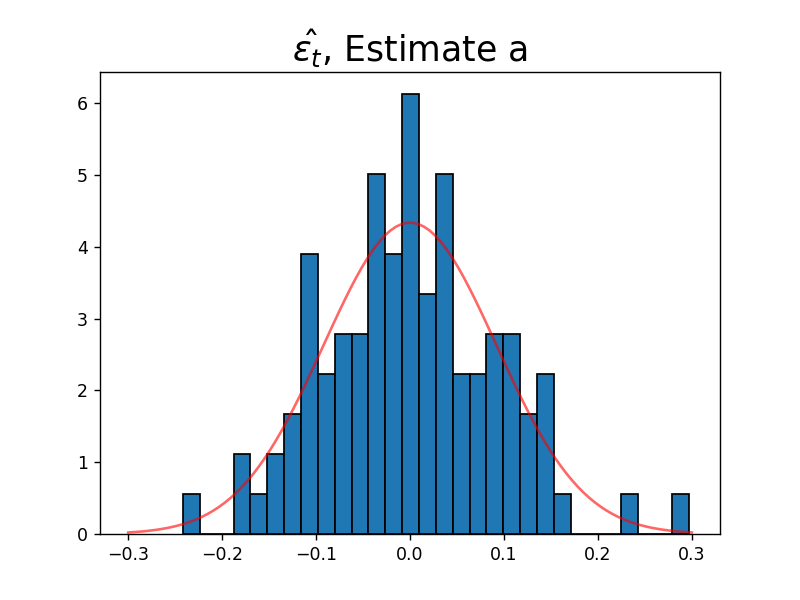

Text(0.5,1,'$\\hat{\\epsilon_t}$, Estimate a')

In [312]:
%matplotlib notebook
z_t = np.log(omega_t/((1-alpha_MLE_a2) * (k_t)**alpha_MLE_a2))
z_t_lag = np.roll(z_t, 1)
z_t_lag[0] = mu_MLE_a2
eps_t_a = z_t - rho_MLE_a2 * z_t_lag - (1 - rho_MLE_a2) * mu_MLE_a2
plt.figure(0)
count, bins, ignored = plt.hist(eps_t_a, 30, edgecolor='black', normed=True)
dist_pts = np.linspace(-0.3, 0.3, 100)
pdf_vals = distribs.norm_pdf(dist_pts, 0, sigma_MLE_a2)
plt.figure(0)
plt.plot(dist_pts,pdf_vals,'r-', alpha=0.6, label='norm pdf')
plt.title('$\hat{\epsilon_t}$, Estimate a', fontsize=20)

### Question b)

Similarly, we will use $(r_t, k_t)$ and equations (4) and (5) to estimate by ML $(\alpha, \rho, \mu, \sigma)$. For that, we can write $z_t$ as:

$$ z_t = ln \Big(\frac{r_t}{\alpha k_t^{\alpha - 1}}\Big) $$
$$ \text{where}\: z_t \sim \mathrm{N}(\rho z_{t-1} + (1 - \rho)\mu,\sigma^2) $$ <br>
which allows us to write our test on our assumption for $\epsilon_t$.

Let's build some auxiliary functions:

In [244]:
def log_lik_norm_b(r_t, k_t, alpha, rho, mu, sigma):
    '''
    --------------------------------------------------------------------
    Calculates z_t series using equations (4) and (5) of PS3.
    Compute the log likelihood function for data eps_t given normal
    distribution parameter sigma.
    --------------------------------------------------------------------
    INPUTS:
    r_t     = (N,) vector, interest rate
    k_t     = (N,) vector, capital
    alpha   = scalar, 0 < alpha < 1
    rho     = scalar, 0 < rho < 1
    mu      = scalar > 0
    sigma   = scalar > 0
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    z_t         = (N,) vector, total factor productivity
    z_t_lag     = (N,) vector, lagged total factor productivity (1 period)
    eps_t       = (N,) vector, AR(1) residual for TFP series
    pdf_vals    = (N,) vector, normal PDF values for mu and sigma
                  corresponding to eps_t
    ln_pdf_vals = (N,) vector, natural logarithm of normal PDF values
                  for mu and sigma corresponding to eps_t
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    z_t = np.log(r_t/(alpha * (k_t)**(alpha-1)))
    z_t_lag = np.roll(z_t, 1)
    z_t_lag[0] = mu
    eps_t = z_t - rho * z_t_lag - (1 - rho) * mu
    pdf_vals = distribs.norm_pdf(eps_t, 0, sigma)
    pdf_vals[pdf_vals < 10^-10] = 10^-10
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [245]:
def crit_zt_b(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params  = (4,) vector, ([alpha, rho, mu, sigma])
    alpha   = scalar, 0 < alpha < 1
    rho     = scalar, 0 < rho < 1
    mu      = scalar > 0
    sigma   = scalar > 0
    args    = length 2 tuple, (omega_t, k_t)
    r_t     = (N,) vector, interest rate
    k_t     = (N,) vector, capital
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_norm_b()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    alpha, rho, mu, sigma = params
    r_t, k_t = args
    log_lik_val = log_lik_norm_b(r_t, k_t, alpha, rho, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Optimization routine: we will use the same procedure adopted in (a).

In [318]:
alpha_init = 0.5
rho_init = 0.5
mu_init = 5
sigma_init = 2

print('alpha_init = ', alpha_init, 'rho_init = ', rho_init, 'mu_init = ', mu_init,
      'sigma_init = ', sigma_init)
#print('alpha_init = ', alpha_MLE_a2, 'rho_init = ', rho_MLE_a2, 'mu_init = ', mu_MLE_a2,
#      'sigma_init = ', sigma_MLE_a2)
#params_init = np.array([alpha_MLE_a2, rho_MLE_a2, mu_MLE_a2, sigma_MLE_a2])
params_init = np.array([alpha_init, rho_init, mu_init, sigma_init])
mle_args = (r_t, k_t)
results3 = opt.minimize(crit_zt_b, params_init, args = (mle_args), method = 'Nelder-Mead')
alpha_MLE_b, rho_MLE_b, mu_MLE_b, sigma_MLE_b = results3.x
print('alpha_MLE_b = ', alpha_MLE_b, 'rho_MLE_b = ', rho_MLE_b, 'mu_MLE_b = ', mu_MLE_b,
      'sigma_MLE_b = ', sigma_MLE_b)

alpha_init =  0.5 rho_init =  0.5 mu_init =  5 sigma_init =  2
alpha_MLE_b =  0.457560320329 rho_MLE_b =  0.720457080609 mu_MLE_b =  9.36949956531 sigma_MLE_b =  0.0919962009728


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log


In [319]:
print(results3)
print("Max-LogLikelihood: ", -results3.fun)

 final_simplex: (array([[ 0.45756032,  0.72045708,  9.36949957,  0.0919962 ],
       [ 0.4575635 ,  0.72045444,  9.36944194,  0.09199615],
       [ 0.457563  ,  0.7204548 ,  9.36945133,  0.09199628],
       [ 0.45756004,  0.72045631,  9.36950454,  0.09199625],
       [ 0.45755745,  0.72045967,  9.36955062,  0.09199635]]), array([-96.70690809, -96.70690809, -96.70690809, -96.70690809, -96.70690809]))
           fun: -96.706908090963211
       message: 'Optimization terminated successfully.'
          nfev: 579
           nit: 342
        status: 0
       success: True
             x: array([ 0.45756032,  0.72045708,  9.36949957,  0.0919962 ])
Max-LogLikelihood:  96.706908091


Results are somewhat similar to (a): though it varies for $\mu$, the other parameters and the maximum loglikelihood are similar.

Let's run in L-BFGS-B:

In [358]:
print('alpha_init = ', alpha_MLE_b, 'rho_init = ', rho_MLE_b, 'mu_init = ', mu_MLE_b,
      'sigma_init = ', sigma_MLE_b)
params_init = np.array([alpha_MLE_b*0.95, rho_MLE_b + 0.2, mu_MLE_b, sigma_MLE_b])
mle_args = (r_t, k_t)
results4 = opt.minimize(crit_zt_b, params_init, args = (mle_args), bounds = ((0.0001, 1 - 0.0001),
                        (-1 + 0.0001, 1 - 0.0001), (0.0001, None), (0.0001, None)),
                        method = 'L-BFGS-B')
alpha_MLE_b2, rho_MLE_b2, mu_MLE_b2, sigma_MLE_b2 = results4.x
print('alpha_MLE_b2 = ', alpha_MLE_b2, 'rho_MLE_b2 = ', rho_MLE_b2, 'mu_MLE_b2 = ', mu_MLE_b2,
      'sigma_MLE_b2 = ', sigma_MLE_b2)

alpha_init =  0.457560320329 rho_init =  0.720457080609 mu_init =  9.36949956531 sigma_init =  0.0919962009728
alpha_MLE_b2 =  0.457153179758 rho_MLE_b2 =  0.72075259808 mu_MLE_b2 =  9.376833174 sigma_MLE_b2 =  0.0919962715288


In [359]:
print(results4)
print("Max-LogLikelihood: ", -results4.fun)
print(results4.hess_inv.todense())

      fun: -96.706906419030389
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.39257519e-03,   1.84741111e-05,   6.13908924e-04,
         9.19442300e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 13
   status: 0
  success: True
        x: array([ 0.45715318,  0.7207526 ,  9.37683317,  0.09199627])
Max-LogLikelihood:  96.706906419
[[ 0.003315   -0.00914881 -0.05824954 -0.00565763]
 [-0.00914881  0.31373965  0.10059853  0.25051318]
 [-0.05824954  0.10059853  1.03723711  0.04956153]
 [-0.00565763  0.25051318  0.04956153  0.20428445]]


In [360]:
# Estimates Qb
print('alpha_MLE_b2 = ', alpha_MLE_b2, '\nrho_MLE_b2 = ', rho_MLE_b2, '\nmu_MLE_b2 = ', mu_MLE_b2,
      '\nsigma_MLE_b2 = ', sigma_MLE_b2)
print("Max-LogLikelihood: ", -results4.fun)
print("VCV(MLE): ", results4.hess_inv.todense())
stderr_alpha_MLE_b2 = np.sqrt(results4.hess_inv.todense()[0,0])
stderr_rho_MLE_b2 = np.sqrt(results4.hess_inv.todense()[1,1])
stderr_mu_MLE_b2 = np.sqrt(results4.hess_inv.todense()[2,2])
stderr_sigma_MLE_b2 = np.sqrt(results4.hess_inv.todense()[3,3])
print('Standard error for alpha estimate = ', stderr_alpha_MLE_b2)
print('Standard error for rho estimate = ', stderr_rho_MLE_b2)
print('Standard error for mu estimate = ', stderr_mu_MLE_b2)
print('Standard error for sigma estimate = ', stderr_sigma_MLE_b2)

alpha_MLE_b2 =  0.457153179758 
rho_MLE_b2 =  0.72075259808 
mu_MLE_b2 =  9.376833174 
sigma_MLE_b2 =  0.0919962715288
Max-LogLikelihood:  96.706906419
VCV(MLE):  [[ 0.003315   -0.00914881 -0.05824954 -0.00565763]
 [-0.00914881  0.31373965  0.10059853  0.25051318]
 [-0.05824954  0.10059853  1.03723711  0.04956153]
 [-0.00565763  0.25051318  0.04956153  0.20428445]]
Standard error for alpha estimate =  0.0575760642211
Standard error for rho estimate =  0.560124675149
Standard error for mu estimate =  1.01844838467
Standard error for sigma estimate =  0.451978374873


Standard error for $\sigma$ (and $\rho$) looks pretty high, though the hessian changes quite a bit if we change the initial parameters. However, results match with our estimates from (a).

Some visual:

<IPython.core.display.Javascript object>


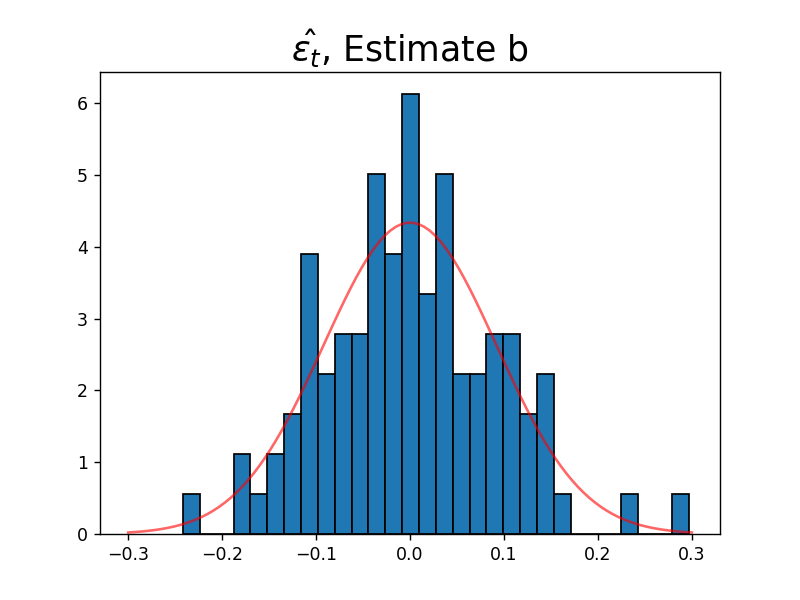

Text(0.5,1,'$\\hat{\\epsilon_t}$, Estimate b')

In [329]:
z_t = np.log(r_t/(alpha_MLE_b2 * (k_t)**(alpha_MLE_b2-1)))
z_t_lag = np.roll(z_t, 1)
z_t_lag[0] = mu_MLE_b2
eps_t_b = z_t - rho_MLE_b2 * z_t_lag - (1 - rho_MLE_b2) * mu_MLE_b2
plt.figure(1)
count, bins, ignored = plt.hist(eps_t_b, 30, edgecolor='black', normed=True)
dist_pts = np.linspace(-0.3, 0.3, 100)
pdf_vals = distribs.norm_pdf(dist_pts, 0, sigma_MLE_b2)
plt.figure(1)
plt.plot(dist_pts,pdf_vals,'r-', alpha=0.6, label='norm pdf')
plt.title('$\hat{\epsilon_t}$, Estimate b', fontsize=20)

### Question c)

We want to estimate the effects of a productivity shock on the interest rate, solving for $P(r_t > 1 | \hat\theta, k_t, z_{t-1})$. Manipulating equation (4) and estimating $z_t \sim N(\hat\rho z_{t-1} + (1 - \hat\rho)\hat\mu, \hat\sigma^2)$:

In [330]:
z_star = np.log(1/(alpha_MLE_a2 * (7500000)**(alpha_MLE_a2-1)))
z_t_lag1 = 10
p_val = 1 - sts.norm.cdf(z_star, loc = rho_MLE_a2 * z_t_lag1 + (1 - rho_MLE_a2) * 
                         mu_MLE_a2, scale = sigma_MLE_a2)
print('Probability that r_t > 1 after shock = ', p_val)

Probability that r_t > 1 after shock =  0.999999944072


That probability is quite high. Does it make sense? Let's analyze what the proposed counterfactual means under our estimates:

<IPython.core.display.Javascript object>


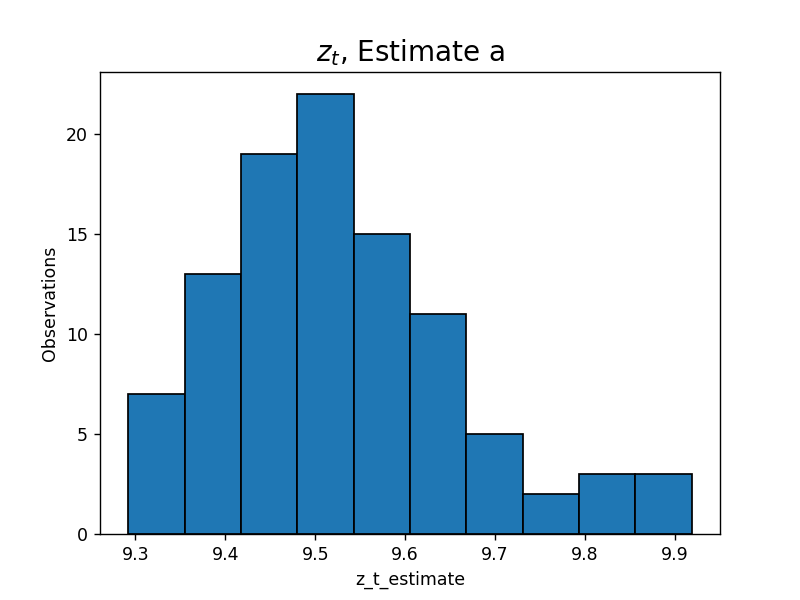

Text(0.5,1,'$z_t$, Estimate a')

In [335]:
z_t_estimate = np.log(omega_t/((1-alpha_MLE_a2) * (k_t)**alpha_MLE_a2))
plt.figure(2)
count, bins, ignored = plt.hist(z_t_estimate, 10, edgecolor='black', normed=False)
plt.xlabel('z_t_estimate')
plt.ylabel('Observations')
plt.title('$z_t$, Estimate a', fontsize=16)

In [336]:
print('z_t_estimate mean = ', z_t_estimate.mean())
print('z_t_max = ', z_t_estimate.max())
print('z_star = ', z_star)
print('sigma_hat = ', sigma_MLE_a2)

z_t_estimate mean =  9.52874931648
z_t_max =  9.91878335086
z_star =  9.38113279972
sigma_hat =  0.0919961777058


According to our estimates, a productivity shock of 10 is well above the value of $z^*$ (or any estimated value of $z_t$, given our macro data), since the estimated standard deviation is only 0.09.

One should also notice that no estimated value of $z_t$ reaches 10. Even though 10 "is not that far away" from our sample, model extrapolation is not advised.

One extra note: after trying some initial parameters on each question, I've realized that the Max-LL is more sensitive to some parameters than others, especially $\sigma$. That way, the solver is, to some degree, indifferent to changes in the other parameters. However, this has an impact on our estimates and, depending on the focus of our research, those results need to be improved.

As an example, the solver also converges to a similar Max-LL value if we start from a lower value of $\mu$. As such, the new estimate for $\mu$ is lower, which has an impact on the distribution of $z_t$, thus changing our analysis of the counterfactual (if that's what we are interested in).